### New KL Upper Bound and Applications

Here we derive an upper bound for the reverse KL divergence and then use it to minimize the reverse KL.

---

First let us write out the reverse KL divergence

$$ \text{KL}(Q || P) = \mathbb{E}_{q}\bigg[\log\frac{q(x)}{p(x)}\bigg] $$

This can be rewritten in information theoretic terms by expanding the expectation

\begin{align}
\mathbb{E}_{q}\bigg[\log\frac{q(x)}{p(x)}\bigg] & = \int q(x) \log \frac{q(x)}{p(x)} dx \\
& = -\int q(x) \log \frac{p(x)}{q(x)} dx \\
& = -\int q(x) \log p(x) dx - \bigg(-\int q(x) \log q(x) \bigg ) dx\\
& = H_p[q] - H[q] \\
\end{align}

Where $H_p[q(x)]$ is the cross entropy and  $H[q(x)]$ is the entropy

We will use the $p(x)$ density function to bound the KL. The term $p(x)$ only appears in the cross entropy

$$\text{KL} = \int q(x)(-\log p(x)) dx - H[q]$$

We will bound $-\log p(x)$ above for certain values of $p(x)$. We know that $p(x)$ is a density function and assume that it is bounded above $p(x) \le 1$. The goal is to use a straight line as the upper bound. Because we assumed $p(x) \le 1$ we make the line pass through $(1,0)$ where $p(x)=1$ and $-\log (p(x))=0$ . The question is, which other point should we use? 

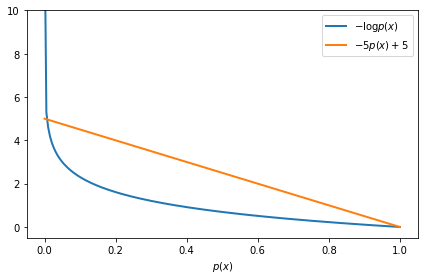

In [1]:
import numpy as np
import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt

x = np.linspace(1e-6,1,200)
y1 = -np.log(x)
y2 = -5*x+5

plt.plot(x,y1,label='$-\log p(x)$',lw=2)
plt.plot(x,y2,label='$-5p(x)+5$',lw=2)
plt.xlabel("$p(x)$")
plt.ylim(-0.5,10)
plt.tight_layout()
plt.legend()
plt.show()

As we see, the $-\log p(x)$ is a convex function and cannot be bounded above by a line for all $p(x)$. However $p(x)$ is a density function and values of $x$ will appear infrequently from regions where $p(x)$ is small. We will choose the other point of the line to be $(\lambda, -\log \lambda)$ with the intention $\lambda \ll 1$. The line passing through these two points can be expressed as 

$$y = \frac{\log \lambda}{1-\lambda}(x-1)$$

We use this line to bound $-\log p(x)$ above for $\lambda \le p(x) \le 1$

$$-\log p(x) \le \frac{\log \lambda}{1-\lambda}\big(p(x)-1\big)$$

For the remainder of this work we define $k=\frac{\log \lambda}{1-\lambda}$

We can now return to the Kullback Leibler divergence between $q(x)$ and $p(x)$. Recall we are bounding with respect to $p(x)$ and the differential entropy term $H[q]$ depends only on $q(x)$, therefore we aren't concerned with the subtraction of a potentially positive quantity while introducing the inequality.

\begin{align}
\text{KL}(q||p) & = \mathbb{E}_q \big[-\log p(x)\big] - H[q] \\
& \le \mathbb{E}_q \big[k\big(p(x)-1\big)\big] - H[q] \\
& \le \int q(x) k\big(p(x)-1\big)dx - H[q] \\
& \le k\bigg(\int p(x)q(x)dx-1\bigg) - H[q] \\
& \le k\big(\mathbb{E}_p \big[q(x)\big] - 1 \big) - H[q] \\
\end{align}

We reiterate that this upper bound only holds for $\lambda \le p(x) \le 1$ and $\lambda \ll 1$. The key observation here, and indeed the entire motivation for this work, was that we completely removed the density $p(x)$ from inside any expectations. Now, the expecatation is over $p(x)$ and we no longer need to explicitly know its functional form. Therefore we can now minimize this upper bound with respect to $q(x)$ without knowing $p(x)$. Before we move onto the final goal of minimization let us examine how tight this bound is on some simple test cases.

### Examining the Upper Bound

The amount of information contained in observation $x$ from $p(x)$ (the universe) is

$$ I(x) = -\log p(x) $$

The expected information contained in $p(x)$ is 

$$ H[p(x)] = \int p(x)\big(-\log p(x)\big) dx$$

The cross entropy is essentially a measurement of  $q(x)$ (the neuron's) interpretation of expected information.

$$ H_p[q(x)] = \int q(x)\big(-\log p(x)\big) dx $$

By replacing $-\log p(x)$ with $k\big(p(x)-1\big)$ we're approximating the amount of information in observations from $p(x)$. In particular we're over estimating the information in high probability events and under estimating the information in low probability events $p(x) \lt \lambda$ where the bound no longer holds.

We begin with two univariate gaussians $P \sim N(\frac{1}{4},1)$ and $Q \sim N(\mu,1)$. We will plot both the true KL and the upper bound for $0 \le \mu \le 1$, $\sigma^2=1$ and $\lambda = 10^{-3}$.

In [2]:
from scipy.integrate import quadrature

def reverse_kl_int(q,p):
    def f_i(x):
        global p
        q_i = q(x)
        p_i = p(x)
        return q_i*np.log(q_i/p_i) 
    quad_rslt, quad_err = quadrature(f_i, -1, 2.0, tol=1e-8, maxiter=100)
    return (quad_rslt, quad_err)

def kl_upper_bound(q,p,l=1e-3,k=None):
    if not k:
        k = np.log(l)/(1-l)
    def f_i(x):
        global p
        q_i = q(x)
        p_i = p(x)
        return q_i*(k*(p_i-1)-np.log(q_i))
    quad_rslt, quad_err = quadrature(f_i, -1, 2.0, tol=1e-8, maxiter=100)
    return (quad_rslt, quad_err)

from scipy.stats import norm
class gmm: # gaussian mixture model
    
    def __init__(self, pis, params, normed=False):
        self.params = params # [[mu1, sig1], [mu2, sig2],...]
        self.components = params.shape[0]
        self.pis = pis
        self.max_val = 1
        self.normed = normed
        if self.normed:
            vals = self.__call__(np.linspace(0,1,10000))
            self.max_val = vals.max()
            
    def __call__(self, x):
        pis = self.pis
        p = self.params
        sz = self.components
        vals = np.array([pis[i]*norm.pdf(x,*(p[i])) for i in range(sz)]).sum(axis=0)
        if self.normed:
            vals /= self.max_val
        return vals
    
    def sample(self, n_samples=1):
        mode_id = np.random.choice(self.components, size=n_samples, replace=True, p=self.pis)
        return np.array([norm.rvs(*(self.params[i])) for i in mode_id])

Below we demonstrate a comparision between KL and the upper bound. We see the upper bound is more sensitive to local extrema and is better at determining the mean of the modes of the distribution. In this particular example we see that the upper bound is able to detect a mode that the true KL cannot.

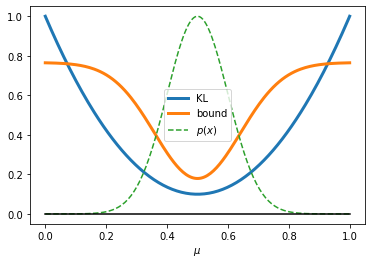

In [11]:
p = gmm([1], np.array([[0.5,0.1]]), normed=True)
mu = np.linspace(0,1,200)

true_kl = []
upper_bound = []
for m in mu:
    q = gmm([1], np.array([[m,0.1]]))
    true_kl.append(reverse_kl_int(q,p)[0])
    upper_bound.append(kl_upper_bound(q,p,l=1e-5)[0])
max_val = np.max((np.max(true_kl),np.max(upper_bound)))    
plt.plot(mu,true_kl/max_val,lw=3,label='KL')
plt.plot(mu,upper_bound/max_val,lw=3,label='bound')
plt.plot(mu,p(mu),ls='dashed',label='$p(x)$')
plt.plot([0,1],[0,0],c='k')
plt.xlabel('$\mu$')
plt.legend()
plt.show()

In [4]:
mu[(np.diff(np.sign(np.diff(upper_bound))) > 0).nonzero()[0] + 1]

array([0.50251256])

In [5]:
mu[(np.diff(np.sign(np.diff(true_kl))) > 0).nonzero()[0] + 1]

array([0.49748744, 0.50251256])

We're still building intution, but it is nice to see that the minimum value of $\mu$ in the upper bound corresponds to approximately the same minimum in the true KL. 

---

Now let's fix $\mu=0$ and vary the variance $0.01 \le \sigma^2 \le 0.1$ of $q(x)$. As before we fix $\lambda = 10^{-3}$.

/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.834575e-07
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.210669e-07
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.653538e-07
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.156036e-07
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.711783e-07
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: ma

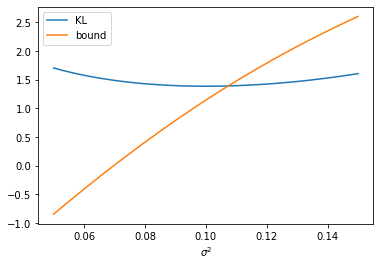

In [6]:
p = gmm([1], np.array([[0.5,0.1]]), normed=True)
var = np.linspace(0.05,0.15,500)

true_kl = []
upper_bound = []
for v in var:
    q = gmm([1], np.array([[0.5,v]]))
    true_kl.append(reverse_kl_int(q,p)[0])
    upper_bound.append(kl_upper_bound(q,p,l=1e-3)[0])
    
plt.plot(var,true_kl,label='KL')
plt.plot(var,upper_bound,label='bound')
plt.xlabel('$\sigma^2$')
plt.legend()
plt.show()

In [7]:
var[(np.diff(np.sign(np.diff(upper_bound))) > 0).nonzero()[0] + 1]

array([], dtype=float64)

In [8]:
var[(np.diff(np.sign(np.diff(true_kl))) > 0).nonzero()[0] + 1]

array([0.1001002])

So things are not quite as easy for the variance. However, likely this is only for $\lambda=10^{-3}$ which we held fixed. If we also minimized across lambda we may see the same minimum of $\sigma^2$ around 1. Let us look for a local minima in the upper bound for all lambda.

iteration =  0


/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.505035e-08
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.291162e-08
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.961029e-08
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.344657e-08
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.217352e-08
  AccuracyWarning)
/home/nathan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:251: AccuracyWarning: ma

iteration =  1
iteration =  2
iteration =  3
iteration =  4
iteration =  5
iteration =  6
iteration =  7
iteration =  8
iteration =  9


ValueError: x and y must have same first dimension, but have shapes (500,) and (5000, 2)

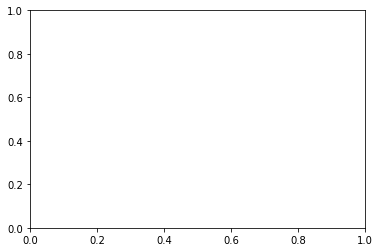

In [9]:
p = gmm([0.1,0.3,0.6], np.array([[-7,1],[0,0.1],[3,0.5]]))
var = np.linspace(0.01,3,500)
ks = np.linspace(-5,-2,10)

true_kl = []
for i,k_val in enumerate(ks):
    print("iteration = ", i)
    upper_bound = []
    for v in var:
        q = gmm([1], np.array([[3,np.sqrt(v)]]))
        true_kl.append(reverse_kl_int(q,p))
        upper_bound.append(kl_upper_bound(q,p,k=k_val))
    out = var[(np.diff(np.sign(np.diff(upper_bound))) > 0).nonzero()[0] + 1]
    if out.size > 0:
        print("Found minima with k = %f", k)
        print(out)
    
plt.plot(var,true_kl,label='KL')
plt.plot(var,upper_bound,label='bound')
plt.xlabel('$\sigma^2$')
plt.legend()
plt.show()

---

To build a little more intuition about the role that $\lambda$ plays in the bound's tightness, let's run the experiment again, but explore $10^{-5} \le \lambda \le 10^{-1}$ while we hold $\mu=2$ and $\sigma^2=1$. In this case we know the true KL should be two. We will only visualize how the upper bound changes.

In [ ]:
lmda = np.linspace(1e-5,0.5,1000)

p = gmm([0.1,0.1,0.2,0.2,0.4], np.array([[-8,1],[-4,1],[-2,3],[-5,1],[9,0.1]]))
q = gmm([1], np.array([[0,0.5]]))
true_kl = reverse_kl_int(q,p,-12,12,1000)
upper_bound = []
for l in lmda:
    upper_bound.append(kl_upper_bound(q,p,-12,12,100,l))

plt.plot([lmda[0],lmda[-1]],[true_kl,true_kl],ls='dashed',label='true KL')
plt.plot(lmda,upper_bound,label='bound')
plt.xlabel('$\lambda$')
plt.legend()
plt.show()

As suspected in the derivation, for the upper bound to be valid, $\lambda$ must remain small. However, if all we are interested in is minimizing the upper bound with respect to the distribution $q(x)$, then $\lambda$ is irrelevant. In addition, at least as far as one previous experiment showed, the parameter values that minimize the upper bound also minimize the KL.

### 3D Plot of the $\mu$ and $\sigma^2$ surface

In [ ]:
from scipy.integrate import quadrature
fig = plt.figure(figsize=(9,5))
#ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(111, projection='3d')

In [ ]:
def E(p,q,m,s,b=1):
    def e_i(x,m,s,b):
        global p
        q_i = q(np.array(x).reshape(-1,1),update=False)
        p_i = p(x)
        return p_i*q_i 
    quad_rslt, quad_err = quadrature(e_i, 0.0, 1.0, args=(m,s,b), tol=1e-6)
    return (-7*(quad_rslt-1)-b*0.5*np.log(2*np.pi*np.e*s), quad_err)

def f(M, S, b=1):
    global p
    Z = np.ndarray(M.shape)
    for mi,m in enumerate(M[:,0]):
        for si,s in enumerate(S[0]):
            q = Neuron([1,1], np.array([m]), s)
            Z[mi,si] = E(p,q,m,s,b)[0]
    return Z


mu_min = 0
mu_max = 1
mu_step = 0.005
s_min = 0.001
s_max = 0.2
s_step = 0.01

M, S = np.mgrid[mu_min:mu_max:mu_step,s_min:s_max:s_step]
#mf = mu.flatten()
#lf = lamda.flatten()
#locs = np.where(1/lf<(1-mf)**2)[0]

Z = f(M,S,b=0.25)
ax3d.plot_surface(M, S, Z, rstride=5, cstride=5, alpha=0.3)
cset = ax3d.contour(M, S, Z, zdir='z', offset=Z.min(), cmap=cm.coolwarm)
cset = ax3d.contour(M, S, Z, zdir='x', offset=mu_min, cmap=cm.coolwarm)
cset = ax3d.contour(M, S, Z, zdir='y', offset=s_max, cmap=cm.coolwarm)

ax3d.set_xlabel('$\mu$')
ax3d.set_xlim(mu_min, mu_max)
ax3d.set_ylabel('$\sigma^2$')
ax3d.set_ylim(s_min, s_max)
ax3d.set_zlabel('$E_P[q(x)]$')

plt.show()
plt.clf()

### Minimizing the Upper Bound

We now explore the minimization of the upper bound.

\begin{align}
\text{KL}(q||p) \le k \big(\mathbb{E}_p \big[q(x)\big] -1\big) - H[q(x)]\\
\end{align}

\begin{align}
\min_{q(x),k} \bigg[ k \big( \mathbb{E}_p \big[q(x)\big] -1\big) - H[q(x)] \bigg ]
\end{align}

We know from information theory the optimal $q(x)$ that minimizes the KL should be $q(x) = p(x)$. This is not the case with the upper bound. We can explore this question with variational methods. We express the objective as a functional and examine the first and second variations.


\begin{align}
J_p[q(x),k] &= k \big( \mathbb{E}_p \big[q(x)\big] -1\big) - H[q(x)] \\
&= \int k q(x)\big(p(x)-1\big) + q(x) \log q(x) dx \\
\end{align}

To simplify notation we drop the parenthesis for the functions, i.e. $q \equiv q(x)$

\begin{align}
J_p[q(x)+\eta(x),k] &= \int k(q+\eta)(p-1) + (q+\eta)\log(q+\eta) dx \\
&=\int kpq + kp\eta -kq -k\eta + (q+\eta)\big[\log(q) + \log(1+\frac{\eta}{q})\big] dx \\
&=\int kpq + kp\eta -kq -k\eta + q\log(q)+\log(q)\eta +(q+\eta)\log(1+\frac{\eta}{q}) dx \\
\end{align}

To find the terms for the second variation we expand the last logarithm in its taylor series

\begin{align}
(q+\eta)\log(1+\frac{\eta}{q}) &= (q+\eta)\big(\frac{\eta}{q} - \frac{\eta^2}{2q^2} + \dots\big) \\
&= \eta - \frac{\eta^2}{2q} + \frac{\eta^2}{q} + \dots \\
&= \eta + \frac{\eta^2}{2q} + \dots
\end{align}

Putting this back in and rearranging the terms yields

\begin{align}
J_p[q(x)+\eta(x),k] = \int kpq -kq +q\log (q)+ (kp-\log q -k-1)\eta + \frac{1}{2q} \eta^2 dx \\
\end{align}

The first variation is 


\begin{align}
\frac{\delta J_p[q(x),k]}{\delta q(x)} &= kp -\log (q)-k -1 \\
\end{align}

If we set it to zero we find that

\begin{align}
0 &= kp - \log q -k-1 \\
q^* &= e^{k(p-1)-1} =  \frac{1}{e}e^{k(p-1)} \\
&= \frac{1}{z}e^{k(p-1)} 
\end{align}

where the $\frac{1}{z}$ term is the normalizing constant. The second variation is

\begin{align}
\frac{\delta^2 J_p[q(x),k]}{\delta q(x)\delta \bar{q}(x)} &= \frac{1}{q}
\end{align}

And because $q(x) > 0$ we know that our upper bound is convex in $q(x)$ and our extrema $q^*(x)$ is a global minimizer for a given $k$.

Unfortunately it is easy to see that our functional $J_p[q(x),k]$ is linear in $k$

\begin{align}
\frac{\partial J_p[q(x),k]}{\partial k} &= \mathbb{E}_p \big[q(x)\big] -1 \\
\frac{\partial^2 J_p[q(x),k]}{\partial k^2} &= 0 \\
\end{align}

We will need another way to determine k. One way to choose $k$ is such that our minimum upper bound $J_p[q^*(x),k]$ is as close as possible to the true KL at the same distribution $KL(q^*(x)||p(x))$. We solve the equation $J_p[q^*(x),k] - KL(q^*(x)||p(x)) = 0$ for $k\lt-1$. 

\begin{align}
J_p[q^*(x),k] - KL(q^*(x)||p(x)) &= k \big( \mathbb{E}_p \big[q^*(x)\big] -1\big) - \mathbb{E}_{q^*}[-\log q^*(x)] - \mathbb{E}_{q^*}\big[-\log p(x) \big] + \mathbb{E}_{q^*}\big[-\log q^*(x)\big]  \\
&= k \big( \mathbb{E}_p \big[q^*(x)\big] -1\big) - \mathbb{E}_{q^*}\big[-\log p(x) \big] \\
\end{align}

By setting this expression to zero and solving for $k$ we find that

\begin{align}
k_1^* = \frac{\mathbb{E}_{q^*}\big[- \log p(x)\big]}{\mathbb{E}_p\big[ q^*(x)\big]-1}
\end{align}

which is a ratio between the true cross entropy and our approximate cross entropy. A subscript was given to distringuish it from a further approximation to $k$. Of course we would need to know the true data generating density $p(x)$ ahead of time. We may have a work around for that which we will explore in the future. For now let us consider another way to determine $k^*$.

Let us choose $k$ such that our upper bound $J[q^*(x),k]$ is $0$ at our given global minimizer. To do this we put $q^*(x)$ back into the upper bound, set it to zero and solve that equation for $k$.

\begin{align}
J_p[q^*(x),k] &= k \big( \mathbb{E}_p \big[q^*(x)\big] -1\big) + \mathbb{E}_{q^*}[\log q^*(x)]
\end{align}

The optimal solution is an exponential so the logarithm of $q^*(x)$ will simply equal the exponent. Recall 

\begin{align}
q^*(x) = \frac{1}{z}e^{k(p-1)}
\end{align}

so the logarithm exposes the $p(x)$ density in the expectation 

\begin{align}
\log q^*(x) = k(p(x)-1) -\log z
\end{align}

Putting this back into the upper bound yields

\begin{align}
J[q^*(x),k] &= k \big( \mathbb{E}_p \big[q^*(x)\big] -1\big) + \mathbb{E}_{q^*}\big[k(p(x)-1)\big] -\log z \\
&= k \big( \mathbb{E}_p \big[q^*(x)\big] - 1 \big ) + k \big( \mathbb{E}_{p}\big[q^*(x)\big] - 1 \big) - \log z
\end{align}

After we combine the terms if we set it to zero and solve for $k$ we get

\begin{align}
k_2^* =  \frac{ \log z }{2 \big( \mathbb{E}_p \big[q^*(x)\big] - 1 \big )} 
\end{align}

The expectation is of the optimal pdf $q^*(x)$ which means it is converged and centered on a local extrema. Recall $q$ is a gaussian with mean $\mu$ and variance $\sigma^2$ and normalizing constant is $z = \sqrt{2 \pi \sigma^2}$. With this in mind we acknowledge that values of $x\sim P$ where $x-\mu$ is large will have little contribution to the expectation so we approximate the expectation as

$$\mathbb{E}_p \big[q^*(x)\big] \approx \mathbb{E}_{q^*} \big[q^*(x)\big] = \frac{1}{2\sigma \sqrt{\pi}}$$

Substituting this into our expression for $k_2^*$ we get

$$k_2^* \approx \frac{1}{2} \frac{\log \sqrt{2 \pi \sigma^2}}{\frac{1}{2 \sigma \sqrt{\pi}}-1} = \frac{\sigma \sqrt{\pi} \log \sqrt{2 \pi \sigma^2}}{1 - 2 \sigma \sqrt{\pi}}$$

Let us breifly examine $k_2^*$ numerically to see if we can simpmlify the expression a bit...


In [ ]:
def k2(s):
    root_pi = np.sqrt(np.pi)
    return -(s*root_pi*np.log(np.e*np.sqrt(2)*root_pi*s))/(1-2*s*root_pi)

s_vals = np.linspace(1e-4,0.2,1000)
plt.plot(s_vals,2*s_vals,s_vals,k2(s_vals))
plt.show()

In [ ]:
np.log(0.001)/(1-0.001)

---

### Minimzation with Parameterized Density

Let us now consider the minimization of the upper bound for a parameterized distribution $q(x|\theta)$.

In particular we assume $q(x|\theta)$ is a multivariate gaussian parameterized by the mean $\boldsymbol{\mu}$ and covariance $\Sigma$. In this work we consider $p(x)$ to be the density of any distribution whose functional form is unknown.

Let $q(\boldsymbol{x} | \theta)$ be the pdf for 
$\mathcal{N}(\boldsymbol{\mu}, \Sigma)$
where $\theta = \{\boldsymbol{\mu}, \Sigma\}$, $\boldsymbol{x},\boldsymbol{\mu} \in {\rm I\!R}^k$ and $\Sigma \in {\rm I\!R}^{k\times k}$.

\begin{equation}
q(\boldsymbol{x} | \theta) = \frac{1}{(2\pi)^{k/2} 
|\Sigma|^{1/2}} \exp \bigg\{ -\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma^{-1}
(\boldsymbol{x}-\boldsymbol{\mu}) \bigg \}
\end{equation}

With $q(x)$ parameterized, the upper bound can be expressed as a function of $k$ and theta $f(k,\theta)$ because both expectations are over $x$. 

\begin{align}
f(k,\theta) &= k \big( \mathbb{E}_p \big[q(\boldsymbol{x} | \theta)\big] -1\big) - H[q(\boldsymbol{x} | \theta)] \\ 
\end{align}

In addition we can calculate the differential entropy of the multivariate gaussian analytically and substitute it into our objective.

\begin{align}
H[q(\boldsymbol{x} | \theta)] &= \frac{1}{2}\log | 2 \pi e \Sigma | \\
f(k,\theta) &= k \big( \mathbb{E}_p \big[q(\boldsymbol{x} | \theta)\big] -1\big) - \frac{1}{2}\log | 2 \pi e \Sigma| \\ 
\end{align}

We now proceed with traditional optimization techniques by setting the gradient with respect to $\theta$ equal to zero. Here we use the pathwise derivative (PD) to calculate the gradient of the expectation. This essentially amounts to moving the gradient inside the integral and thus inside the expectations. This procedure is always valid provided the argument of the expectation is continuous and everywhere differentiable.

\begin{equation}
\nabla_{\theta} f = k\mathbb{E}_p \big[ \nabla_{\theta} q(x|\theta)\big] - \big(0,\frac{1}{2}\Sigma^{-1} \big)^T\\
\end{equation}

To allow more transparent analysis we express the gradient in terms of its components

\begin{align}
\frac{\partial f}{\boldsymbol{\mu}} &= k\mathbb{E}_p \big[ \frac{\partial q(x|\boldsymbol{\mu}, \Sigma)}{\partial \boldsymbol{\mu}} \big] \\
\frac{\partial f}{\partial \Sigma} &= k\mathbb{E}_p \big[ \frac{\partial q(x|\boldsymbol{\mu}, \Sigma)}{\partial \Sigma} \big] - \frac{1}{2}\Sigma^{-1} \\
\end{align}

We begin by recalling the partials of the multivariate gaussian pdf for both the mean $\boldsymbol{\mu}$ and the covariance $\Sigma$.

\begin{align}
\frac{\partial q}{\boldsymbol{\mu}} &= q(x|\theta) \Sigma^{-1} (\boldsymbol{x}-\boldsymbol{\mu}) \\
\frac{\partial q}{\partial \Sigma} &= -q(x|\theta) \frac{1}{2}(\Sigma^{-1}-\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma^{-1}) \\
\end{align}

(see appendix for derivations)

Substituting these back into our gradient terms we arrive at

\begin{align}
\frac{\partial f}{\boldsymbol{\mu}} &= k\mathbb{E}_p \big[ q(x|\theta) \Sigma^{-1} (\boldsymbol{x}-\boldsymbol{\mu}) \big] \\
\frac{\partial f}{\partial \Sigma} &= k\mathbb{E}_p \big[ -q(x|\theta) \frac{1}{2}(\Sigma^{-1}-\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma^{-1}) \big] - \frac{1}{2}\Sigma^{-1} \\
\end{align}

We can now employ the Robbins-Monroe algorithm to determine the optimal parameters for the gaussian $q(x)$. We assume for now that the $x$'s are sampled i.i.d. from $p(x)$ and we update the gaussian in an online manner. To ease notation we introduce a few substitutions. We let $q_n = q(x_n|\boldsymbol{\mu}_n, \Sigma_n)$ and $C_n = (\boldsymbol{x}_n-\boldsymbol{\mu}_n)(\boldsymbol{x}_n-\boldsymbol{\mu}_n)^T$ which is the empirical Fisher matrix that approximates the Hessian giving us second order information in our update. After observing the $n^{\text{th}}$ sample from $p$ we update the gaussian as follows.


\begin{align}
\boldsymbol{\mu}_{n+1} &= \boldsymbol{\mu}_n + \alpha k q_n \Sigma_n^{-1} (\boldsymbol{x}_n-\boldsymbol{\mu}_n)   \\
\Sigma_{n+1} &= \Sigma_n + \beta k q_n \big( \Sigma_n^{-1} C_n \Sigma_n^{-1} - \Sigma_n^{-1} \big) + \gamma\Sigma^{-1} \\
\end{align}

The constants $\alpha$, $\beta$, and $\gamma$ are terms to ensure dimensional consistency. They are often given the misnomer of step size. This is not the case as the gradient terms are not normalized and steps are not of size $\alpha$, $\beta$ or $\gamma$.

This stochastic optimization allows our update to be online and the learning objective is to minimize the reverse KL between a single gaussian and the unknown distribution. Recall that minimizing the reverse Kullback-Leibler divergence is mode seeking, so the gaussian will move towards a nearby local extrema in the unknown distribution $p(x)$. 

Now let us take a look at the second derivatives

\begin{align}
\frac{\partial^2 q}{\boldsymbol{\mu}^2} &= q(x|\theta) \big( (\boldsymbol{x}-\boldsymbol{\mu})^T \Sigma^{-2} (\boldsymbol{x}-\boldsymbol{\mu}) - \Sigma^{-1} \big) \\
\frac{\partial q}{\partial \Sigma} &= -q(x|\theta) \frac{1}{2}(\Sigma^{-1}-\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma^{-1}) \\
\end{align}


We take a moment now interpret what this learning rule is doing. Reducing the equations to a single dimension allows for an easier interpretation.

\begin{align}
\boldsymbol{\mu}_{n+1} &= \boldsymbol{\mu}_n + \alpha q_n \frac{\boldsymbol{x}_n - \boldsymbol{\mu}_n}{\sigma_n^2}  \\
\sigma_{n+1}^2 &= \sigma_n^2 + \beta \frac{q_n}{2} \bigg( \big(\frac{\boldsymbol{x}_n - \boldsymbol{\mu}_n}{ \sigma_n^2}\big)^2 - \frac{1}{\sigma_n^2} \bigg) + \gamma\frac{1}{\sigma_n^2} \\
\end{align}

Visualizations depiciting the learning process to come...

In [ ]:
from ipywidgets import interactive
class neuron():
    def __init__(self, mu_0, var_0, a=1, b=1):
        self.mu = mu_0
        self.var = var_0
        self.a = a
        self.b = b
        self.calls = 0
        
    def __call__(self, x, update=False):
        self.calls += 1
        z = x-self.mu
        x2 = x + np.random.rand()*self.var
        z2 = x2-self.mu
        norm_const = 1/np.sqrt(2*np.pi*self.var)
        output = norm_const*np.exp(-np.power(z,2)/(2*self.var))
        output2 = norm_const*np.exp(-np.power(z2,2)/(2*self.var))
       
        if update:
            #self.mu += self.a*output*(z/self.var)
            #self.var += self.b/2*output*(np.power(z/self.var,2)-(1/self.var)) + 1/self.var
            self.mu += self.a*output*z
            #z2 = x-self.mu
            #self.var += self.b*output/2*(np.power(z,2)-self.var) + 1/self.var
            #self.mu += self.a*0.5*(output*(z/self.var)+output2*(z2/self.var))
            #self.var += self.b*0.5*(output*(np.power(z/self.var,2)-(1/self.var))+output2*(np.power(z2/self.var,2)-(1/self.var))) + 1/self.var
            assert self.var > 0, 'ERROR: $\sigma^2 \le 0$'

        return output

p = gmm([0.3,0.7], np.array([[-7,1], [3,1]]))
q = neuron(-2,1,1,2)
t = np.linspace(-11,10,1000)
true_kl = []
upper_bound = []

def f(i=0):
    x = p.sample()
    y = q(x, update=True)
    true_kl.append(reverse_kl_int(q,p,-10,10,100))
    upper_bound.append(kl_upper_bound(q,p,-10,10,100))
    fig, ax = plt.subplots(1, 2, figsize=(12,5), dpi=80)
    ax[0].plot([x,x],[0.0,1.0],c='k', label='$x\sim p(x)$')
    ax[0].plot(t, p(t), c='r', lw=3, label='$p(x)$')
    ax[0].plot(t, q(t), c='b', lw=3, label='$q(x)$')
    ax[0].legend()
    ax[1].plot(true_kl, label='KL')
    ax[1].plot(upper_bound, label='bound')
    ax[1].set_xlabel('$q(x)$')
    ax[1].set_title('KL Divergence and Upper Bound')
    ax[1].legend()
    plt.show()

interactive_plot = interactive(f, i=(0, 1000))
output = interactive_plot.children[-1]
#output.layout.height = '35px'
interactive_plot

To build some intuition about the stability issues lets examine closely the cost surface for each iteration

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm


def f(mu,var,x):
    x = np.array(x)
    N = x.size
    val = 0
    c = 2*var
    for xi in x:
        val += (xi-mu)**2
    return np.exp(-(N/2)*np.log(c*np.pi) - (1/c)*val) + 0.5*np.log(c*np.pi*np.e)

mu_min = 0.5
mu_max = 1.5
mu_step = 0.01
var_min = 0.001
var_max = 2.0
var_step = 0.01

mu,var = np.mgrid[mu_min:mu_max:mu_step,var_min:var_max:var_step]
#mf = mu.flatten()
#sf = sigma.flatten()
#locs = np.where(1/sf<(1-mf)**2)[0]

z = f(mu,var,[1])
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot_surface(mu, var, z, rstride=2, cstride=2, alpha=0.3)
cset = ax.contour(mu, var, z, zdir='z', offset=0.04, cmap=cm.coolwarm)
cset = ax.contour(mu, var, z, zdir='x', offset=mu_min, cmap=cm.coolwarm)
cset = ax.contour(mu, var, z, zdir='y', offset=var_max, cmap=cm.coolwarm)

ax.set_xlabel('$\mu$')
ax.set_xlim(mu_min, mu_max)
ax.set_ylabel('$\sigma^2$')
ax.set_ylim(var_min, var_max)
ax.set_ylim(var_min, var_max)
ax.set_zlim(bottom=0)
ax.set_zlabel('$f$')

plt.show()

### Cost Surface

A common point of confusion when first computing maximum likelihood solutions is about what function is being optimized. Our probability density function (pdf) $q(x;\mu,\lambda)$ is a function of the events $x$ from our random variable $X$ and is parameterized by $\mu$ and $\lambda$. For example when $\mu=1$ and $\lambda=5$

$$q(x;\mu=1,\lambda=5) = \sqrt{\frac{5}{2 \pi}}\exp\{-\frac{5}{2}(x-1)^2 \}$$

We see clearly $q$ depends only on $x$ and its plot is shown in the figure below

In [ ]:
t = np.linspace(0,2,100)
q = gmm([1], np.array([[1,1/5]]))
q_y = q(t)
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t,q_y)
plt.show()

The confusion arises when we apply the optimization definition directly which says we must find the variable $x$ that maximizes the pdf. This is just a little mathematical slight of hand resulting from an imprecise specification of exactly what function is being optimized. When we observe values of the random variable $x$ we view the function $q(x; \mu, \lambda)$ differently. The observed random variable becomes the parameter and $q$ becomes a function of both $\mu$ and $\lambda$. It is no longer required to be a pdf as the integral over both $\mu$ and $\lambda$ is not guaranteed to equal 1. This is made clear by defining a new function for when $x$ is observed.

$$f(\mu,\lambda;\ x_0) =: q(x_0; \mu, \lambda)$$

For example when the random variable $x$ assumes a value $x=1$ the plot of $f(\mu,\lambda;x=1)$ is shown below.

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def f(mu,lamda,x):
    x = np.array(x)
    N = x.size
    val = 0
    c = lamda/2
    for xi in x:
        val += (xi-mu)**2
    return np.exp((N/2)*np.log(c/np.pi) - c*val)

mu_min = -1
mu_max = 3
mu_step = 0.05
l_min = 0.1
l_max = 5
l_step = 0.05

mu,lamda = np.mgrid[mu_min:mu_max:mu_step,l_min:l_max:l_step]
mf = mu.flatten()
lf = lamda.flatten()
locs = np.where(1/lf<(1-mf)**2)[0]

z = f(mu,lamda,[1])
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot_surface(mu, lamda, z, rstride=5, cstride=5, alpha=0.3)
cset = ax.contour(mu, lamda, z, zdir='z', offset=0.04, cmap=cm.coolwarm)
cset = ax.contour(mu, lamda, z, zdir='x', offset=mu_min, cmap=cm.coolwarm)
cset = ax.contour(mu, lamda, z, zdir='y', offset=l_max, cmap=cm.coolwarm)

ax.set_xlabel('$\mu$')
ax.set_xlim(mu_min, mu_max)
ax.set_ylabel('$\lambda$')
ax.set_ylim(l_min, l_max)
ax.set_zlabel('$f$')

plt.show()

I would like to visualize the surface of $KL(q(x|\mu,\sigma)||p(x))$ for different $\mu$ and $\sigma$. To do this, we must choose a $p(x)$ to hold fixed, and then compute the KL for a range of values of $\mu$ and $\sigma$. We can then display the results as a surface in 3D. Let us choose $p(x)$ to be a standard normal with mean 0 and standard deviation 1. I defined a function above which calculates the value of the KL divergence for a set $q(x)$ and $p(x)$ using a numerical integration technique. I redefine it here and add comments for ease of use

In [ ]:
def reverse_kl_int(q,p,beg,end,n_samples):
    """Calculate the Reverse Kullback-Leibler Divergence between two density functions q(x) and p(x).
        q - a density function defined using the gmm class above.
        p - a density function defined using the gmm class above.
        beg - the beginning of the interval which to integrate over.
        end - the end of the interval which to integrate over.
        n_samples - the number of sample points within the interval to use in the integral approximation.
    """
    a = beg
    b = end
    samples = np.linspace(a,b,n_samples)
    qs = q(samples)
    return (qs*np.log(qs/p(samples))).sum()*((b-a)/n_samples)

Below we define a standard normal distribution. We use the gaussian mixture model (gmm) class but only define a single gaussian at mean $\mu=0$ and standard deviation $\sigma=1$ with a weight of $\pi=1$. So it is a regular univariate guassian.

In [ ]:
p = gmm([1], np.array([[0,1]]))

Now we need to iteratively define many different $q(x)$ gaussians for means varying from $-3 \le \mu \le 3$ and standard deviations varying from $0.1 \le \sigma \le 2.1$ (double for loop) and for each one we need to calculate the KL divergence using the above function reverse_kl_int. For all of the $q(x)$ densities use beg=-6, end=6, and n_samples=1000. Save all of these results into a matrix and then plot them using 3D plotting routines such as the one demonstrated above in this notebook.

---
### MAP

We have observed that stochastic approximation in the current problem is difficult. It is sensitive to learning rate parameters. This suggests that there may be an approach to determining them that is intrinsic to the problem. While we are also exploring this route, for now we breifly identify another alternative that may aleviate some of the responsibility the parameters currently bear.

Rather than minimizing the divergence between $q(x|\theta)$ and $p(x)$, let us consider the partial KL between $q(x,\theta)$ and $p(x)$. Here we define the partial KL to be over only the $x$ random variable. In other words it is the gradient of $KL(q(x,\theta)||p(x))$ with respect to $\theta$ and the the output would be a function of $\theta$. A $\theta^*$ that minimizes this is a local extrema of the full $KL(q(x,\theta)||p(x))$.

\begin{align}
KL(q(x,\theta)||p(x)) &= \int \int q(x,\theta) \log \frac{q(x,\theta)}{p(x)} dx d\theta \\
\nabla_\theta KL(q(x,\theta)||p(x)) &= \int q(x,\theta) \log \frac{q(x,\theta)}{p(x)} dx \\
&= \int q(x|\theta)q(\theta) \log \frac{q(x|\theta)q(\theta)}{p(x)} dx \\
\end{align}

The goal is for $q(x)$ to be as close to $p(x)$ as possible. Given that, it is interesting to see the term in the log resembling the posterior $q(\theta|x)$. This approach seems to be a proxy for MAP.

\begin{align}
\nabla_\theta KL(q(x,\theta)||p(x)) &= \int q(x|\theta)q(\theta) \log \frac{q(x|\theta)q(\theta)}{p(x)} dx \\
& = q(\theta) \int q(x|\theta) \log \frac{q(x|\theta)}{p(x)} dx +q(\theta) \log q(\theta) \\
& = q(\theta) KL(q(x|\theta)||p(x)) +q(\theta) \log q(\theta) \\
\end{align}

We use the upper bound derived previously

\begin{align}
\nabla_\theta KL(q(x,\theta)||p(x)) &= q(\theta) KL(q(x|\theta)||p(x)) +q(\theta) \log q(\theta) \\
&\le q(\theta) \bigg(\frac{\log \lambda}{1-\lambda} \mathbb{E}_p \big[q(x|\theta)\big] -  \frac{\log \lambda}{1-\lambda} - H[q] \bigg) +q(\theta) \log q(\theta) \\
\end{align}

We once again wish to minimize the upper bound with respect to $\theta$. This reduces to

\begin{align}
min_\theta J(\theta) &\le min_\theta \bigg[ q(\theta) \bigg(\frac{\log \lambda}{1-\lambda} \mathbb{E}_p \big[q(x|\theta)\big] -  \frac{\log \lambda}{1-\lambda} - H[q] \bigg) +q(\theta) \log q(\theta) \bigg]\\
&= max_\theta \big[ q(\theta) \big(\mathbb{E}_p \big[q(x|\theta)\big] + H[q] \big) + q(\theta) \log q(\theta) \big]\\
\end{align}

for $\lambda \ll 1$ and $q(\theta) \lt 1$. If we choose our prior to be improper such that $p(\theta) = 1$ This approach reduces to the maximum likelihood approach we derived earlier. The hope is that if we choose priors that constrain the gaussian parameters to reasonable values then the optimization problem may be less sensitive to  the learning rates.

### Information Gain

It is edifying to consider a third approach. We would like to choose the next set of parameters $\theta_{i+1}$ such that we always gain information. We define $G_P(q_i, q_{i+1})$ to be the information gained when moving from $q_i$ to $q_{i+1}$ relative to a distribution $P$.

\begin{align}
G_P(q_i, q_{i+1}) = KL(q(x|\theta_i)||p(x))-KL(q(x|\theta_{i+1})||p(x))
\end{align}

We would like to maximizing the information gain $G$ with respect to the next set of parameters $\theta_{i+1}$. We were already at $\theta_i$ so we treat them as known and the maximization reduces to

\begin{align}
\max_{\theta_{i+1}} G_P(q_i, q_{i+1}) &= \max_{\theta_{i+1}} \bigg[KL(q(x|\theta_i)||p(x)) -KL(q(x|\theta_{i+1})||p(x)) \bigg] \\
&= \min_{\theta_{i+1}} \bigg[KL(q(x|\theta_{i+1})||p(x)) \bigg] \\
\end{align}

And we see we're left with the same minimization problem that we initially posed and can use the same upper bound previously derived.

Firing threholds change in neurons... 

@article{azouz2000dynamic,
  title={Dynamic spike threshold reveals a mechanism for synaptic coincidence detection in cortical neurons in vivo},
  author={Azouz, Rony and Gray, Charles M},
  journal={Proceedings of the National Academy of Sciences},
  volume={97},
  number={14},
  pages={8110--8115},
  year={2000},
  publisher={National Acad Sciences}
}